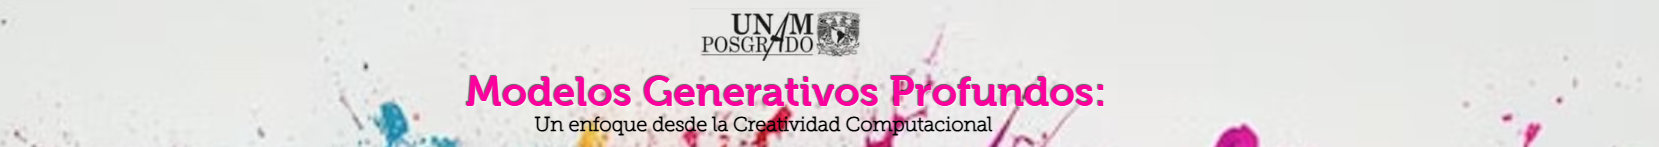

# Control Latente en StyleGAN2-ADA
#### Direcciones Semánticas, Interpolaciones y Mezclas — *FFHQ (Flickr-Faces-HQ*




En este cuaderno aprenderás cómo controlar un modelo **StyleGAN preentrenado** mediante el **espacio latente**.  
Aprenderás a:

- **Descubrir direcciones semánticas disentangled** en el espacio latente (por ejemplo, edad, cabello, género).  
- **Interpolar** a lo largo de esas direcciones para observar transiciones suaves entre atributos.  
- **Combinar códigos latentes** (*style mixing*) para crear imágenes híbridas que fusionen estructura y detalles de distintas muestras.  


##1. Instalar ninja y pycuda

**ninja:** Sistema de compilación optimizado que coordina la construcción rápida de módulos en C++ y CUDA, utilizado por PyTorch y otras librerías para acelerar la generación de extensiones nativas durante la instalación o el entrenamiento en GPU.

**pycuda:** Proporciona una interfaz directa entre Python y CUDA, permitiendo ejecutar kernels en la GPU, gestionar memoria y realizar operaciones de cómputo paralelo de bajo nivel necesarias para modelos como StyleGAN.

In [ ]:
!pip install ninja
!pip install pycuda # ermite ejecutar kernels personalizados o inspeccionar la memoria de la GPU directamente desde Python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 12.5 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2025.1.2-cp312-cp312-linux_x86_64.whl size=659050 sha256=77100acd5d851a8e71957572a38e89ef0f95b19c000291d76798d6b6ac685ae0
  Stored in directory: /root/.cache/pip/wheels/d5/36/f3/ac5f09d768cad3fa15d5a3449bdfe65c3de58e69d036c73228
Successfully built pycuda


##2. Cargar StyleGAN2-ADA preentrenado (FFHQ) - NVIDIA oficial

Entrenado a resolución 1024×1024.

In [ ]:
# 1. Clonar el repositorio oficial
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
%cd stylegan2-ada-pytorch

# 2. Instalar dependencias básicas
!pip install -q torch torchvision matplotlib numpy requests tqdm

# 3. Descargar el modelo preentrenado de rostros humanos FFHQ (1024×1024)
!wget -q https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl

# 4. Cargar el modelo en GPU
import torch
import legacy
import numpy as np
import matplotlib.pyplot as plt
import pickle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with open('ffhq.pkl', 'rb') as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device)  # generador entrenado

print("Modelo StyleGAN2-FFHQ cargado correctamente.")

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 131 (delta 0), reused 0 (delta 0), pack-reused 129 (from 2)
Receiving objects: 100% (131/131), 1.13 MiB | 4.91 MiB/s, done.
Resolving deltas: 100% (57/57), done.
/content/stylegan2-ada-pytorch
Modelo StyleGAN2-FFHQ cargado correctamente.


##3. Generar y visualizar imágenes base
  <ol>
    <li><strong>Latentes aleatorios:</strong> crea <code>n_images</code> vectores <code>z</code> en el espacio latente (<code>G.z_dim</code>).</li>
    <li><strong>Inferencia sin gradientes:</strong> ejecuta <code>G(z, c)</code> dentro de <code>torch.no_grad()</code> para ahorrar memoria y acelerar la ejecución ya que estamos en modo inferencia.</li>
    <li><strong>Truncation:</strong> aplica <code>truncation_psi = 0.7</code> para equilibrar realismo y diversidad en las imágenes generadas.
    <ul>
      <li>Valores bajos (≈ 0.5) producen imágenes más realistas y estables.
      </li>
      <li>Valores altos (≈ 1.0) producen imágenes más variadas pero a veces menos coherentes. </li>
      <li>En este caso, 0.7 busca un equilibrio entre realismo y diversidad. </li>
    </ul>
    </li>
    <li><strong>Ruido determinista:</strong> usa <code>noise_mode="const"</code> para resultados reproducibles.</li>
    <li><strong>Escalado y visualización:</strong> reescala el tensor de <code>[-1, 1]</code> a <code>[0, 1]</code> y muestra las imágenes con Matplotlib.</li>
  </ol>
  <p><strong>Salida:</strong> una cuadrícula de rostros realistas generados por StyleGAN2-FFHQ, listos para inspección visual.</p>


Setting up PyTorch plugin "bias_act_plugin"... 

W1019 04:45:32.104000 1037 torch/utils/cpp_extension.py:2425] TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
W1019 04:45:32.104000 1037 torch/utils/cpp_extension.py:2425] If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'] to specific architectures.


Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... 

W1019 04:45:59.763000 1037 torch/utils/cpp_extension.py:2425] TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
W1019 04:45:59.763000 1037 torch/utils/cpp_extension.py:2425] If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'] to specific architectures.


Done.


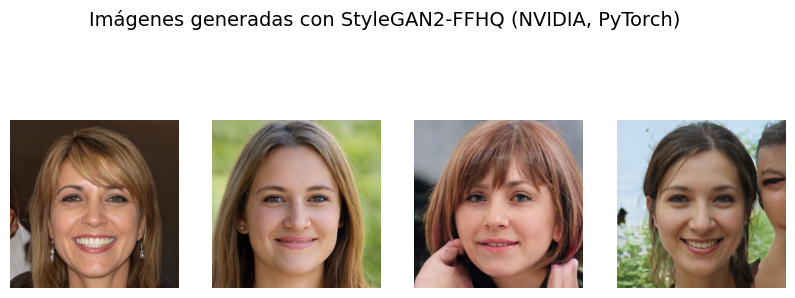

In [ ]:
n_images = 4
z_dim = G.z_dim
z = torch.randn(n_images, z_dim, device=device)  # vectores latentes aleatorios
c = None  # sin etiquetas (modelo no condicional)

with torch.no_grad(): #Desactiva el cálculo del gradiente porque estamos en modo inferencia
    imgs = G(z, c, truncation_psi=0.7, noise_mode='const')

# Escalar a [0, 1] y mostrar
imgs = (imgs.clamp(-1, 1) + 1) / 2

plt.figure(figsize=(10, 4))
for i in range(n_images):
    plt.subplot(1, n_images, i + 1)
    plt.imshow(np.transpose(imgs[i].cpu().numpy(), (1, 2, 0)))
    plt.axis("off")
plt.suptitle("Imágenes generadas con StyleGAN2-FFHQ (NVIDIA, PyTorch)", fontsize=14)
plt.show()


##4. Control latente

###4.1 Control latente continuo por interpolación entre dos códigos z
**Idea:** observar cómo cambia la identidad o combinar rasgos de distintos códigos latentes.

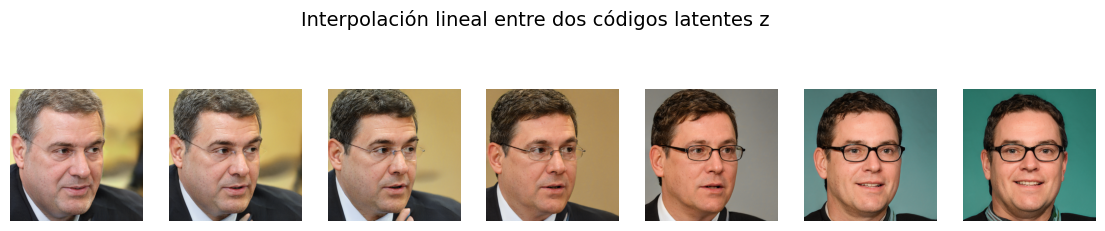

In [ ]:
#  Control latente por interpolación entre dos códigos z

z1 = torch.randn(1, G.z_dim, device=device)
z2 = torch.randn(1, G.z_dim, device=device)

steps = 7
alphas = np.linspace(0, 1, steps)
imgs = []

with torch.no_grad():
    for a in alphas:
        z_interp = (1 - a) * z1 + a * z2
        img = G(z_interp, None, truncation_psi=0.7, noise_mode='const')
        imgs.append((img.clamp(-1, 1) + 1) / 2)

plt.figure(figsize=(14, 3))
for i, img in enumerate(imgs):
    plt.subplot(1, steps, i + 1)
    plt.imshow(np.transpose(img[0].cpu().numpy(), (1, 2, 0)))
    plt.axis("off")
plt.suptitle("Interpolación lineal entre dos códigos latentes z", fontsize=14)
plt.show()


###4.2 Espacio disentangled

####4.2.1 Descubrir direcciones semánticas
**Idea:** el espacio intermedio
𝑊 de StyleGAN2 se puede descomponer en direcciones que corresponden a atributos visuales.
Usaremos PCA para encontrar direcciones dominantes — sin etiquetas — y observar cómo cada una afecta el resultado.

**¿Qué observarás?**

Cambios suaves en edad aparente, género, expresión, iluminación, etc.

Estas variaciones emergen sin supervisión: el modelo ya codifica los ejes semánticos internamente.

Puedes explorar más componentes cambiando: components[i]

In [ ]:
# ============================================================
# Control latente disentangled con PCA en el espacio W
# ============================================================

from sklearn.decomposition import PCA
import numpy as np
import torch
import matplotlib.pyplot as plt

# 1️. Generar vectores latentes z y proyectarlos a W
n_samples = 200
torch.manual_seed(42)
z = torch.randn(n_samples, G.z_dim, device=device)

with torch.no_grad():
    w = G.mapping(z, None)  # proyección al espacio W (shape [200, 18, 512])
w_np = w[:, 0, :].cpu().numpy()  # tomamos una capa representativa (capa 0)

# 2️. PCA: descubrir direcciones semánticas no supervisadas
pca = PCA(n_components=5)
pca.fit(w_np)
components = pca.components_

print("PCA aplicado sobre W. Varianza explicada:", np.round(pca.explained_variance_ratio_, 3))

PCA aplicado sobre W. Varianza explicada: [0.09  0.073 0.068 0.064 0.055]


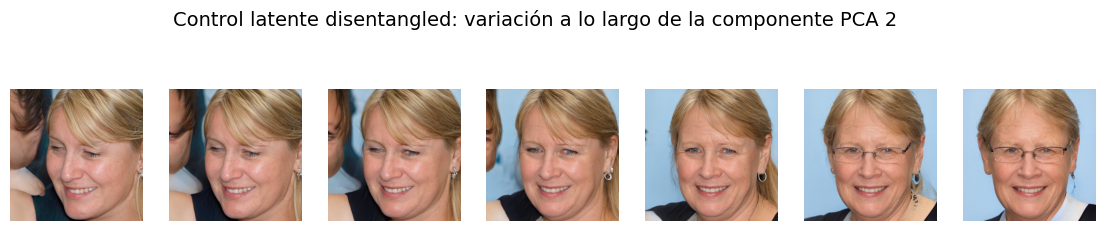

In [ ]:
# 3️. Visualizar el efecto de una componente PCA (dirección semántica fija)

# Seleccionar componente (0 a 4)
ic = 1

# Generar nuevos vectores base z → w (sin semilla fija)
n_images = 5
z = torch.randn(n_images, G.z_dim, device=device)
with torch.no_grad():
    w_base = G.mapping(z, None)

# Definir valores de desplazamiento
alpha_values = np.linspace(-4, 4, 7)
direction = torch.from_numpy(components[ic]).to(device).reshape(1, 1, 512)

imgs = []
with torch.no_grad():
    for a in alpha_values:
        w_mod = w_base.clone()
        w_mod += a * direction  # aplicar desplazamiento
        img = G.synthesis(w_mod, noise_mode='const')
        imgs.append((img.clamp(-1, 1) + 1) / 2)

# 4️. Mostrar resultados
plt.figure(figsize=(14, 3))
for i, img in enumerate(imgs):
    plt.subplot(1, len(imgs), i + 1)
    plt.imshow(np.transpose(img[0].cpu().numpy(), (1, 2, 0)))
    plt.axis("off")

plt.suptitle(f"Control latente disentangled: variación a lo largo de la componente PCA {ic+1}", fontsize=14)
plt.show()


####4.2.2 Interpolación en una dirección semántica conocida (**edad**) en el espacio W

In [ ]:
# ============================================================
# Descarga de direcciones semánticas publicadas (InterFaceGAN)
# ============================================================

!mkdir -p boundaries
!wget -q -O boundaries/age_boundary.npy https://github.com/genforce/interfacegan/raw/master/boundaries/stylegan_ffhq_age_boundary.npy
!wget -q -O boundaries/smile_boundary.npy https://github.com/genforce/interfacegan/raw/master/boundaries/stylegan_ffhq_smile_boundary.npy

print("Direcciones descargadas correctamente.")


Direcciones descargadas correctamente.


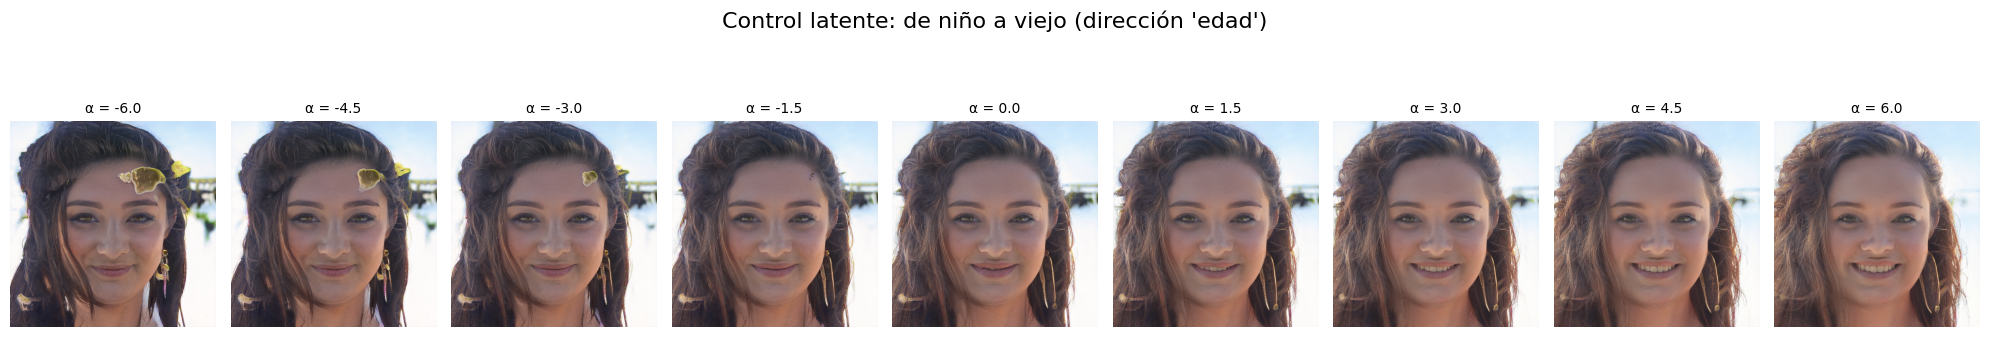

In [ ]:
# ============================================================
# Control latente: "Edad"
# ============================================================

import torch
import numpy as np
import matplotlib.pyplot as plt

# 1. Dirección "edad" (normalizada)
age_dir = np.load("boundaries/age_boundary.npy")
age_dir = torch.from_numpy(age_dir).to(device)
age_dir = age_dir / torch.norm(age_dir)

# 2. Identidad base
z = torch.randn(1, G.z_dim, device=device)
with torch.no_grad():
    w = G.mapping(z, None)

# 3. Rango moderado y continuo
#    ±6 suele ser el máximo seguro para mantener coherencia
alpha_values = np.linspace(-6, 6, 9)

# 4️. Aplicar dirección con peso decreciente en capas altas
imgs = []
with torch.no_grad():
    for a in alpha_values:
        w_mod = w.clone()
        # estructura (capas 0–6): efecto fuerte
        w_mod[:, :7, :] += a * 1.2 * age_dir
        # expresión/media (capas 7–11): efecto medio
        w_mod[:, 7:12, :] += a * 0.7 * age_dir
        # textura fina (capas 12–17): efecto leve
        w_mod[:, 12:, :] += a * 0.25 * age_dir

        img = (G.synthesis(w_mod, noise_mode='const').clamp(-1, 1) + 1) / 2
        imgs.append(img)

# 5. Visualización
plt.figure(figsize=(20, 4))
for i, (a, img) in enumerate(zip(alpha_values, imgs)):
    plt.subplot(1, len(alpha_values), i + 1)
    plt.imshow(np.transpose(img[0].cpu().numpy(), (1, 2, 0)))
    plt.title(f"α = {a:.1f}", fontsize=10)
    plt.axis("off")

plt.suptitle("Control latente: de niño a viejo (dirección 'edad')", fontsize=16, y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()



####4.2.3 Interpolación en una dirección semántica conocida (**sonrisa**) en el espacio W

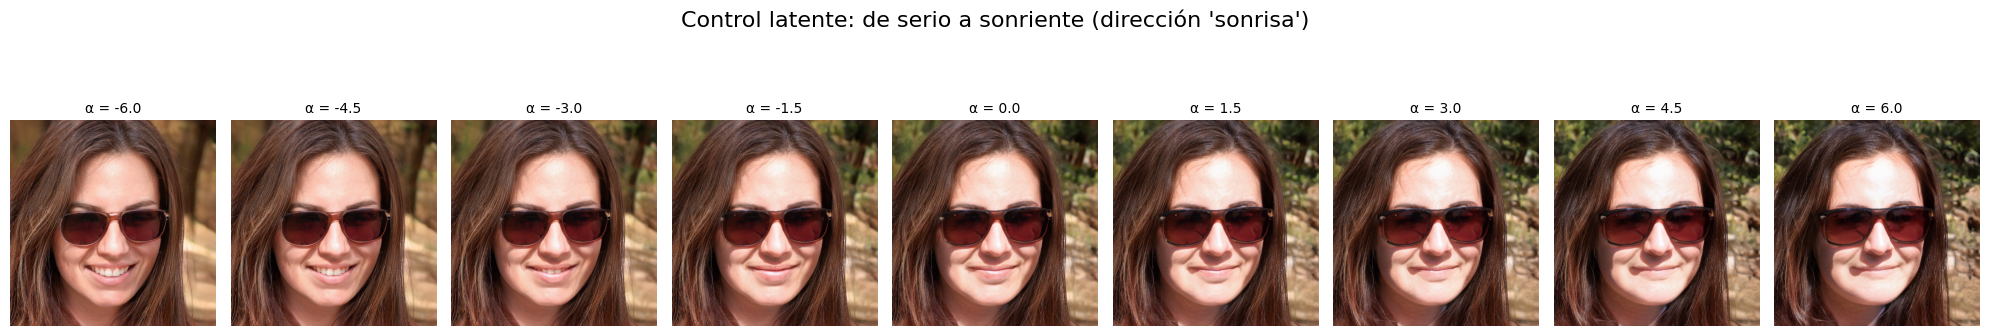

In [ ]:
# ============================================================
# Control latente: "Sonrisa"
# ============================================================

import torch
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Dirección "edad" (normalizada)
smile_dir = np.load("boundaries/smile_boundary.npy")
smile_dir = torch.from_numpy(smile_dir).to(device)
smile_dir = smile_dir / torch.norm(smile_dir)

# 2. Identidad base
z = torch.randn(1, G.z_dim, device=device)
with torch.no_grad():
    w = G.mapping(z, None)

# 3. Rango moderado y continuo
#    ±6 suele ser el máximo seguro para mantener coherencia
alpha_values = np.linspace(-6, 6, 9)

# 4️. Aplicar dirección con peso decreciente en capas altas
imgs = []
with torch.no_grad():
    for a in alpha_values:
        w_mod = w.clone()
        # estructura (capas 0–6): efecto fuerte
        w_mod[:, :7, :] += a * 1.2 * smile_dir
        # expresión/media (capas 7–11): efecto medio
        w_mod[:, 7:12, :] += a * 0.7 * smile_dir
        # textura fina (capas 12–17): efecto leve
        w_mod[:, 12:, :] += a * 0.25 * smile_dir

        img = (G.synthesis(w_mod, noise_mode='const').clamp(-1, 1) + 1) / 2
        imgs.append(img)

# 5. Visualización
plt.figure(figsize=(20, 4))
for i, (a, img) in enumerate(zip(alpha_values, imgs)):
    plt.subplot(1, len(alpha_values), i + 1)
    plt.imshow(np.transpose(img[0].cpu().numpy(), (1, 2, 0)))
    plt.title(f"α = {a:.1f}", fontsize=10)
    plt.axis("off")

plt.suptitle("Control latente: de serio a sonriente (dirección 'sonrisa')", fontsize=16, y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()



####4.2.4 Combinación Lineal de Direcciones Semánticas en el Espacio W (**edad y sonrisa**)
Combinar dos atributos independientes (por ejemplo, edad y expresión) usando direcciones publicadas

Este experimento muestra que las direcciones latentes pueden combinarse linealmente, generando nuevas identidades o transiciones semánticas compuestas —una demostración empírica de que el espacio
W de StyleGAN2 posee una estructura localmente lineal y disentangled.

<ul>
  <li>Se toma un vector <i>w</i> base (una identidad aleatoria o conocida).</li>
  <li>Se aplican dos desplazamientos latentes independientes:</li>
  <ul>
    <li>uno en la dirección <b>“edad”</b></li>
    <li>otro en la dirección <b>“sonrisa”</b></li>
  </ul>
  <li>Se combinan gradualmente para observar cómo el modelo sintetiza <b>jóvenes serios</b>, <b>adultos sonrientes</b>, <b>adultos serios</b>, etc.</li>
</ul>

<p>
El resultado puede representarse como una <b>rejilla 3×3</b>, donde:
</p>

<ul>
  <li>las <b>filas</b> representan variaciones en la sonrisa, y</li>
  <li>las <b>columnas</b> representan variaciones en la edad.</li>
</ul>


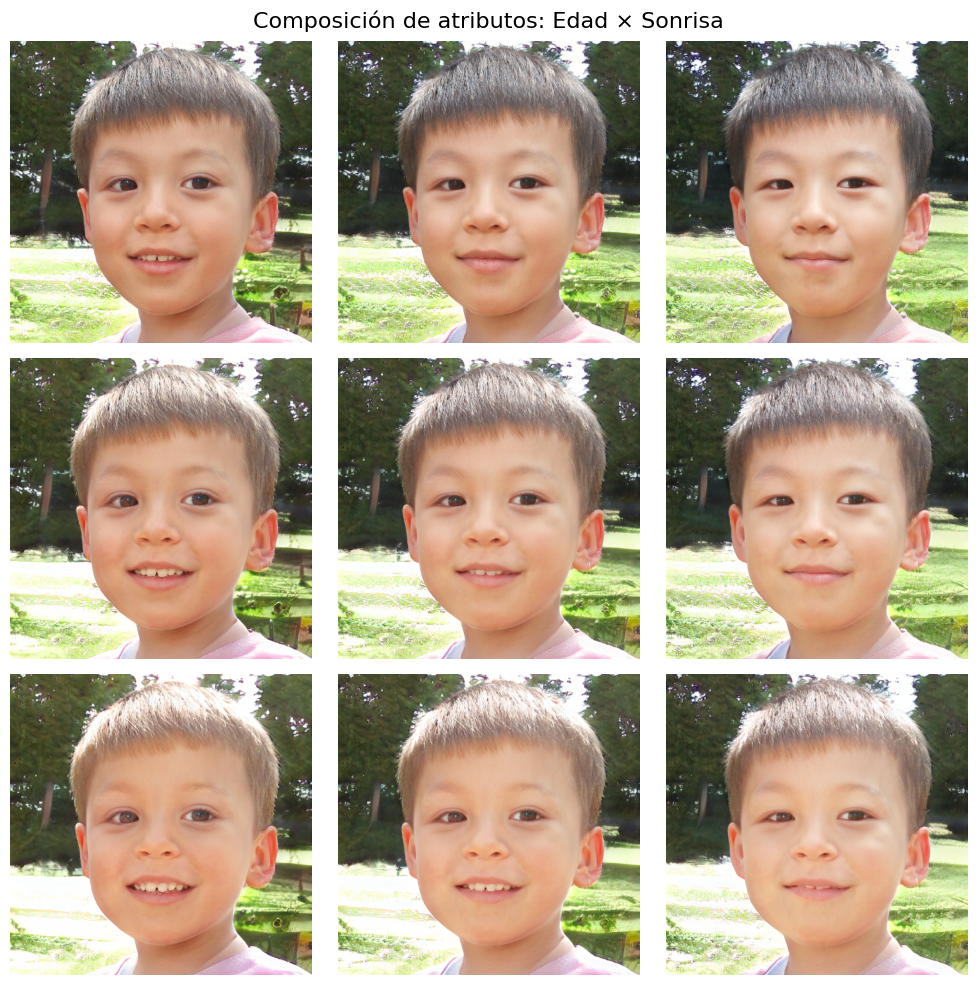

In [ ]:
# ============================================================
# Experimento: Composición de direcciones latentes (Edad + Sonrisa)
# ============================================================


#Codifica aquí tu respuesta

###4.3 Mezcla de estilos (Style Mixing)

**¿Qué observarás?**

El rostro “mezclado” combina la estructura facial del primero (capas bajas)
con el color de piel, cabello o textura del segundo (capas altas).

Si cambias crossover, puedes decidir a partir de qué nivel de detalle se mezclan:

crossover=4 → cambia forma global.

crossover=8 → cambia color y textura.

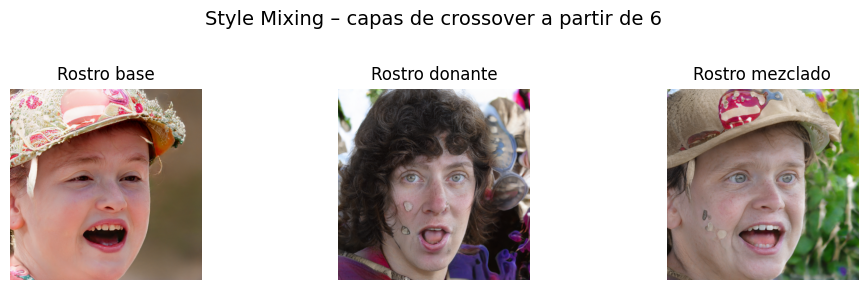

In [ ]:
# Control latente por mezcla de estilos (Style Mixing)

z_src = torch.randn(1, G.z_dim, device=device)  # rostro fuente (forma)
z_dst = torch.randn(1, G.z_dim, device=device)  # rostro destino (textura)

with torch.no_grad():
    w_src = G.mapping(z_src, None)
    w_dst = G.mapping(z_dst, None)

crossover = 6  # capa donde se combinan los estilos
w_mix = w_src.clone()
w_mix[:, crossover:, :] = w_dst[:, crossover:, :]

with torch.no_grad():
    img_src = (G.synthesis(w_src, noise_mode='const').clamp(-1, 1) + 1) / 2
    img_dst = (G.synthesis(w_dst, noise_mode='const').clamp(-1, 1) + 1) / 2
    img_mix = (G.synthesis(w_mix, noise_mode='const').clamp(-1, 1) + 1) / 2

# Mostrar resultados
titles = ["Rostro base", "Rostro donante", "Rostro mezclado"]
plt.figure(figsize=(10, 3))
for i, (img, t) in enumerate(zip([img_src, img_dst, img_mix], titles)):
    plt.subplot(1, 3, i + 1)
    plt.imshow(np.transpose(img[0].cpu().numpy(), (1, 2, 0)))
    plt.title(t, fontsize=12)
    plt.axis("off")

plt.suptitle(f"Style Mixing – capas de crossover a partir de {crossover}", fontsize=14, y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()
